In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/datasetml/images/"
CAPTIONS_FILE = "/content/drive/MyDrive/datasetml/captions.json"
FEATURES_DIR = "/content/drive/MyDrive/datasetml/features_npy2/"

In [ ]:
import os
os.makedirs(FEATURES_DIR, exist_ok=True)

In [ ]:
# load vgg16 model
model = VGG16()

# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


sarthak

In [ ]:
# extract features from images (YOUR VERSION)

features = {}

for img_name in tqdm(os.listdir(IMAGE_DIR)):

    # full image path
    img_path = os.path.join(IMAGE_DIR, img_name)

    # load the image
    image = load_img(img_path, target_size=(224, 224))

    # convert image pixels to numpy array
    image = img_to_array(image)

    # reshape data for model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2])
    )

    # preprocess image for VGG
    image = preprocess_input(image)

    # extract features
    feature = model.predict(image, verbose=0)

    # get image ID
    image_id = img_name.split('.')[0]

    # store feature (SAME AS HIS)
    features[image_id] = feature


  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
import os
import pickle

PICKLE_PATH = "/content/drive/MyDrive/datasetml/features.pkl"

with open(PICKLE_PATH, 'wb') as f:
    pickle.dump(features, f)


In [ ]:
with open(PICKLE_PATH, 'rb') as f:
    features = pickle.load(f)

In [ ]:
import json

with open(CAPTIONS_FILE, "r") as f:
    raw_json = json.load(f)

captions = {}

for img, caption in raw_json.items():
    cleaned = caption.strip().lower()
    cleaned = cleaned.replace('"', '').replace(" ,", ",").replace(" .", ".")
    captions[img] = ["startseq " + cleaned + " endseq"]

print("Total captions:", len(captions))


Total captions: 15000


In [ ]:
import re

def clean(captions):
    for img_id, caps in captions.items():
        for i in range(len(caps)):
            caption = caps[i]

            # convert to lowercase
            caption = caption.lower()

            # remove digits & special characters
            caption = re.sub('[^a-z]', ' ', caption)

            # remove extra spaces
            caption = re.sub('\s+', ' ', caption).strip()

            # save back
            caps[i] = caption


<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2071281210.py:15: SyntaxWarning: invalid escape sequence '\s'
  caption = re.sub('\s+', ' ', caption).strip()


In [ ]:
clean(captions)
print(list(captions.values())[0])


['startseq a man in a blue and red shirt hugs a woman in a blue top endseq']


In [ ]:
all_captions = []

for img_id in captions:
    for caption in captions[img_id]:
        all_captions.append(caption)


In [ ]:
all_captions[:10]

['startseq a man in a blue and red shirt hugs a woman in a blue top endseq',
 'startseq young boy holding a light saber in front of a christmas tree with wrapping paper littering the floor endseq',
 'startseq an native looking older man is sitting and working on making an item that looks to be similar to his hat or bag which is beside him endseq',
 'startseq two young blond women wearing summer dresses talk to a young blond man wearing a dress navy uniform in front of a battleship endseq',
 'startseq a boy and a girl are bending under a fence to look over a ledge endseq',
 'startseq a young woman dancing with an old man while other people watch endseq',
 'startseq a little girl with a yellow shirt swings while a little girl in green watches endseq',
 'startseq two men outside looking at metalwork objects endseq',
 'startseq performers are performing for an audience endseq',
 'startseq several motorcycle policemen driving on a street or parking lot in a wooded area endseq']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# vocabulary size
vocab_size = len(tokenizer.word_index) + 1

vocab_size


9031

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

max_length


80

In [ ]:
# FIX captions keys: remove .jpg extension
captions = {
    k.split('.')[0]: v
    for k, v in captions.items()
}

# verify fix
print("Sample feature keys:", list(features.keys())[:3])
print("Sample caption keys:", list(captions.keys())[:3])

# check intersection size
print("Common keys:", len(set(features.keys()).intersection(set(captions.keys()))))


Sample feature keys: ['4122645918', '3225037367', '1176580356']
Sample caption keys: ['4567734402', '2137071442', '127332812']
Common keys: 15000


In [ ]:
common_keys = list(set(features.keys()).intersection(set(captions.keys())))

split = int(len(common_keys) * 0.90)
train = common_keys[:split]
test  = common_keys[split:]

print("Train size:", len(train))
print("Test size:", len(test))
print("Sample train ID:", train[0])


Train size: 13500
Test size: 1500
Sample train ID: 470754768


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

def data_generator(data_keys, captions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for key in data_keys:
            caps = captions[key]

            for caption in caps:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical(out_seq, num_classes=vocab_size)

                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1

                    if n == batch_size:
                        # 🔥 IMPORTANT: yield TUPLE, not list
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        X1, X2, y = [], [], []
                        n = 0


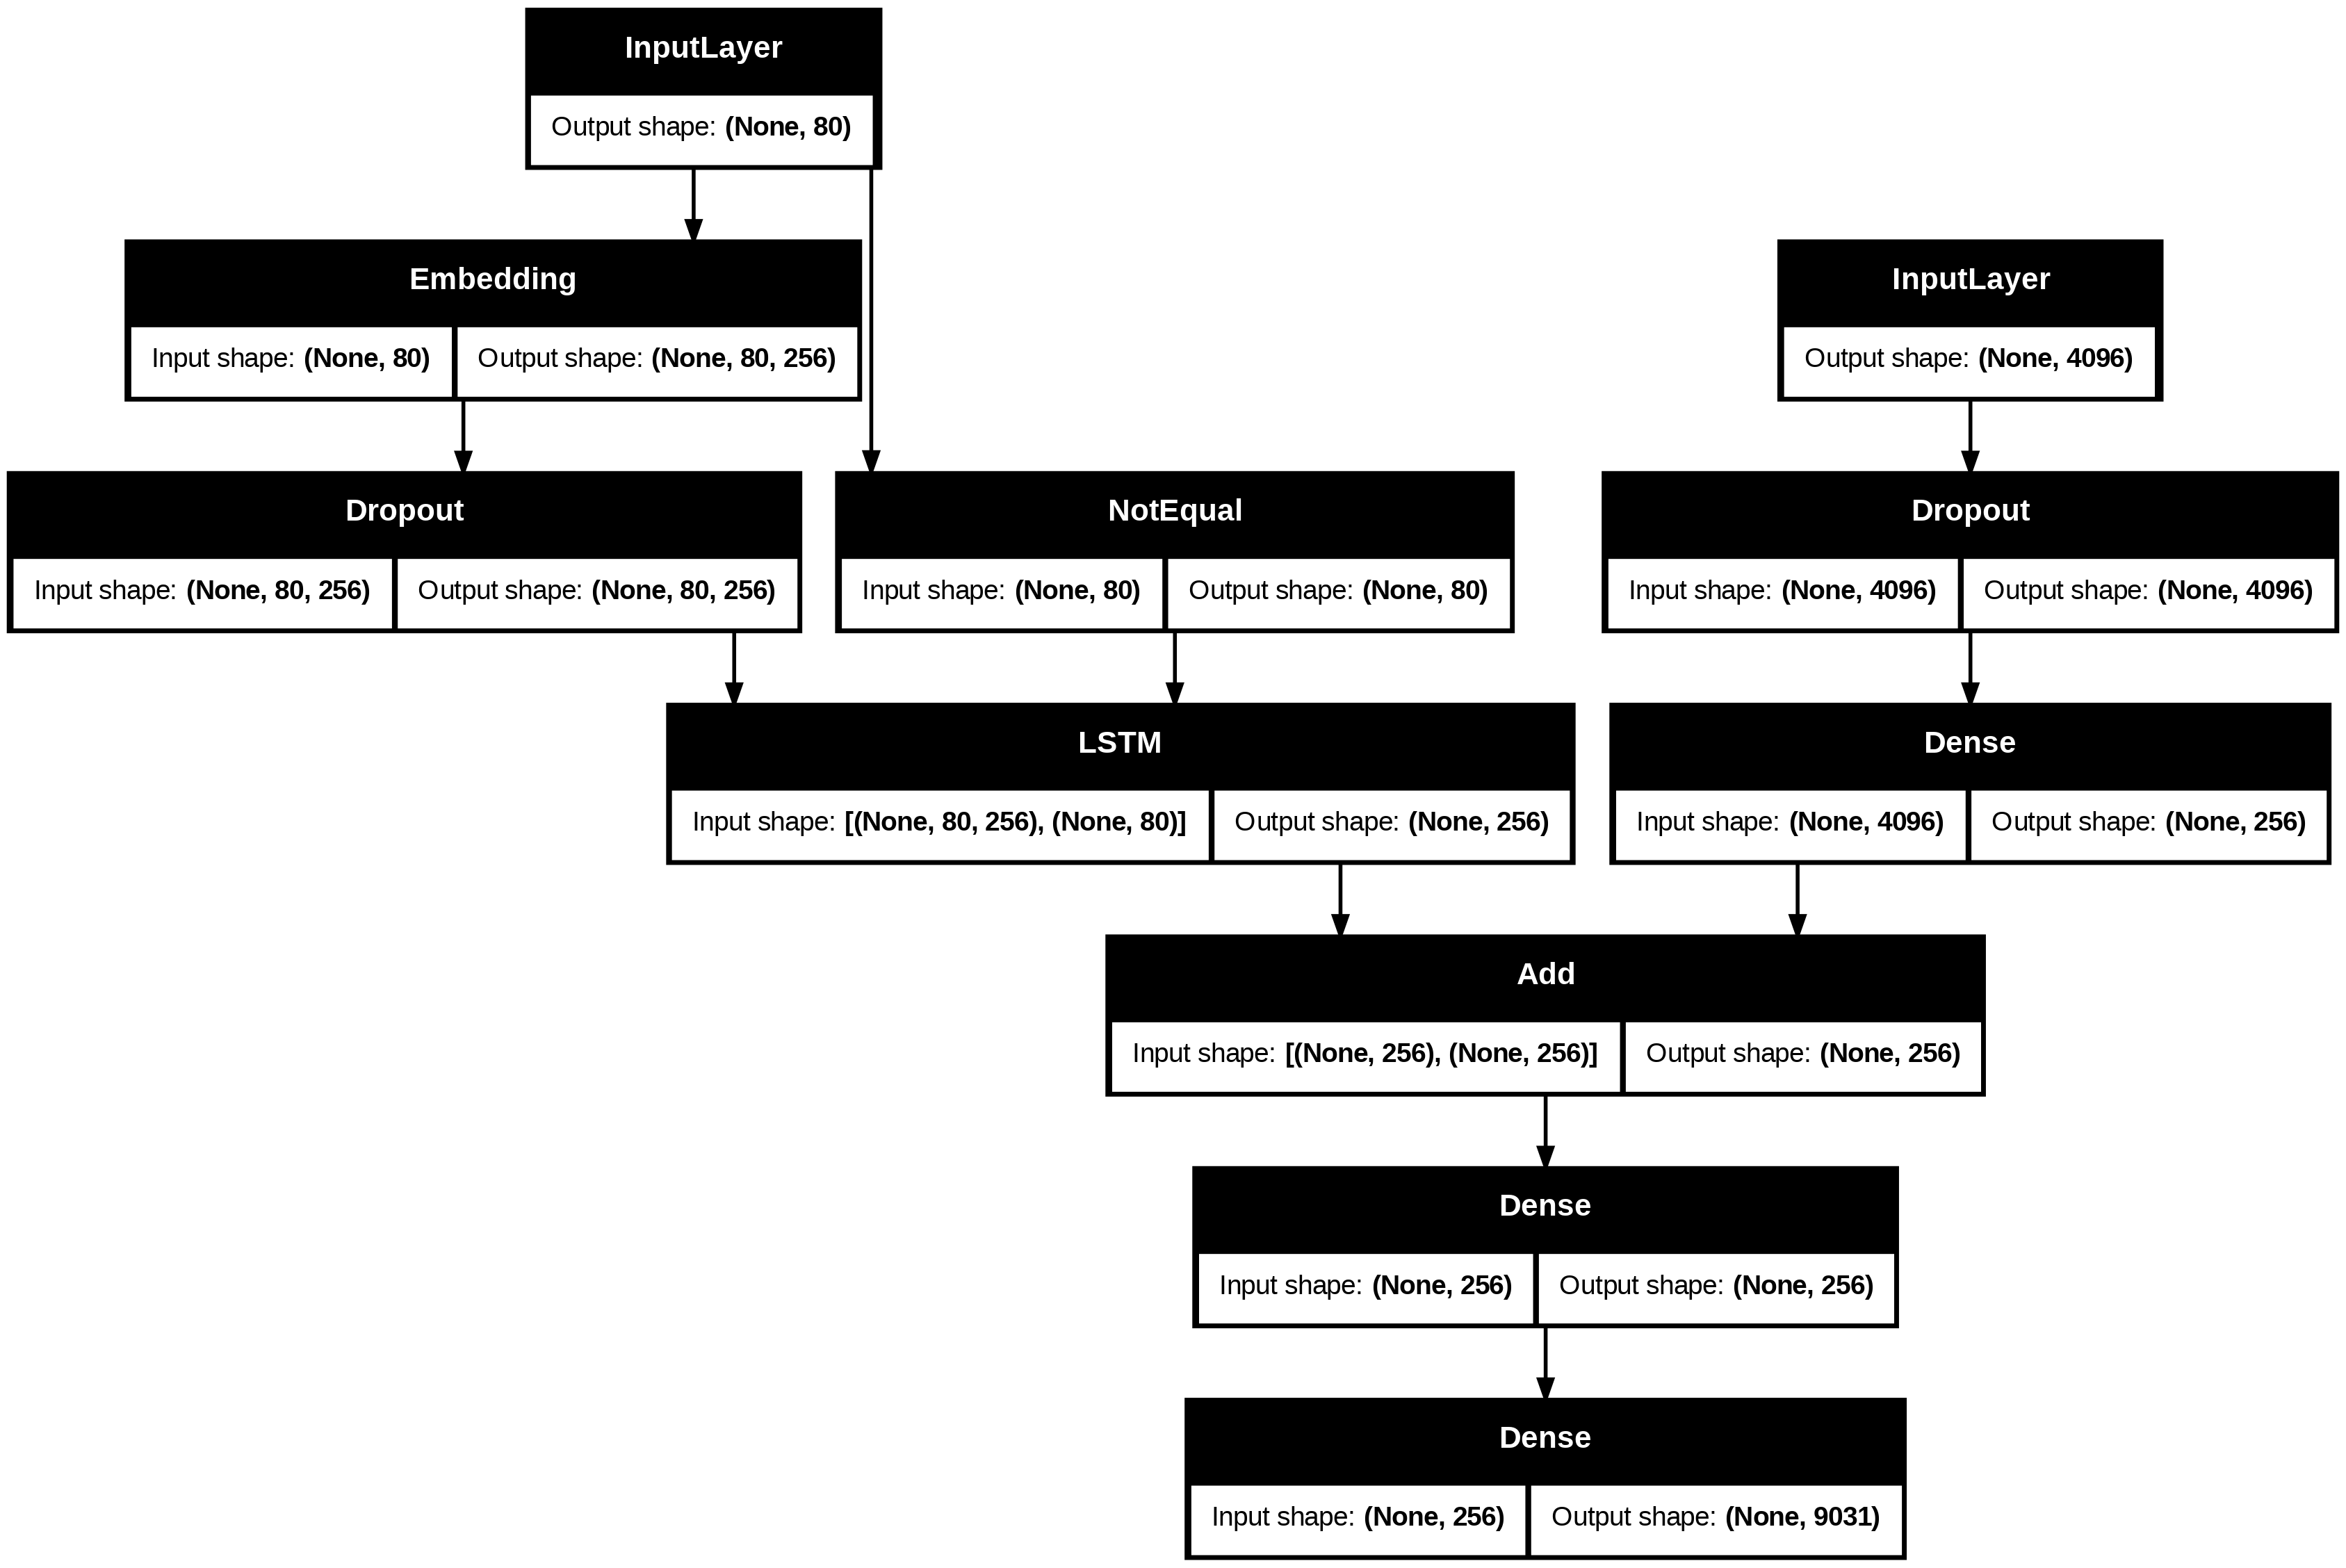

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)

# 🔥 FIX HERE
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam'
)
plot_model(model, show_shapes=True)


In [ ]:
# training parameters
epochs = 65
batch_size = 64
steps = len(train) // batch_size

# create generator
generator = data_generator(
    train,
    captions,
    features,
    tokenizer,
    max_length,
    vocab_size,
    batch_size
)

# train model (Keras 3 compatible)
model.fit(
    generator,
    steps_per_epoch=steps,
    epochs=epochs,
    verbose=1
)


Epoch 1/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 6.5301
Epoch 2/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 5.5388
Epoch 3/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 5.3853
Epoch 4/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 5.1004
Epoch 5/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 4.9218
Epoch 6/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 4.7593
Epoch 7/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 4.6844
Epoch 8/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4.6716
Epoch 9/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 4.5698
Epoch 10/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 4.5035
Epoch 11/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4.4895
Epoch 12/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 4.5173
Epoch 13/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4.3718
Epoch 14/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 4.3205
Epoch 15/65
210/210 ━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
import pickle
import os

BASE_PATH = "/content/drive/MyDrive/datasetml"
os.makedirs(BASE_PATH, exist_ok=True)

# save tokenizer
with open(f"{BASE_PATH}/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# save max_length
with open(f"{BASE_PATH}/max_length.pkl", "wb") as f:
    pickle.dump(max_length, f)

# save vocab_size
with open(f"{BASE_PATH}/vocab_size.pkl", "wb") as f:
    pickle.dump(vocab_size, f)

print("✅ tokenizer, max_length, vocab_size saved")


✅ tokenizer, max_length, vocab_size saved


In [ ]:
import os

CHECKPOINT_DIR = "/content/drive/MyDrive/datasetml/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

MODEL_PATH = f"{CHECKPOINT_DIR}/caption_model_best.keras"
model.save(MODEL_PATH)

print(" Model saved at:", MODEL_PATH)


✅ Model saved at: /content/drive/MyDrive/datasetml/checkpoints/caption_model_best.keras


In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# build inference-safe model (non-cuDNN)
def build_inference_model(vocab_size, max_length):
    # image feature branch
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # caption branch
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)

    # 🔥 IMPORTANT: disable cuDNN
    se3 = LSTM(256, use_cudnn=False)(se2)

    # decoder
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    return model


# build model
model = build_inference_model(vocab_size, max_length)

# load trained weights (NO retraining)
model.load_weights(
    "/content/drive/MyDrive/datasetml/checkpoints/caption_model_best.keras"
)

print("✅ Inference model loaded (non-cuDNN, weights reused)")


✅ Inference model loaded (non-cuDNN, weights reused)


In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [ ]:
import numpy as np

def sample_top_k(preds, k=5):
    preds = preds.flatten()
    top_k_indices = np.argsort(preds)[-k:]
    top_k_probs = preds[top_k_indices]
    top_k_probs = top_k_probs / np.sum(top_k_probs)
    return np.random.choice(top_k_indices, p=top_k_probs)


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def predict_caption(model, image, tokenizer, max_length):
    in_text = "startseq"

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        yhat = model.predict([image, sequence], verbose=0)
        yhat = sample_top_k(yhat, k=5)   # 👈 ONLY CHANGE

        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == "endseq":
            break

    return in_text


In [ ]:
 from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# validate with test data
actual, predicted = [], []

for key in tqdm(test):
    # get actual captions
    caps = captions[key]

    # predict caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    # split into words
    y_pred = y_pred.split()

    # remove start/end tokens from prediction
    y_pred = [word for word in y_pred if word not in ['startseq', 'endseq']]

    # prepare actual captions
    actual_captions = []
    for cap in caps:
        cap_words = cap.split()
        cap_words = [word for word in cap_words if word not in ['startseq', 'endseq']]
        actual_captions.append(cap_words)

    # append to lists
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLEU scores
print("BLEU-1:", corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2:", corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


100%|██████████| 1500/1500 [43:04<00:00,  1.72s/it]


BLEU-1: 0.24185975609756097
BLEU-2: 0.12119946281756859


In [ ]:
print("BLEU-3:", corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4:", corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-3: 0.06603546532589043
BLEU-4: 0.037543020166563044


self

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def show_caption(image_name):
    # remove extension to get image_id
    image_id = image_name.split('.')[0]

    # image path (your Drive structure)
    img_path = os.path.join(
        "/content/drive/MyDrive/datasetml/images",
        image_name
    )

    # load image
    image = Image.open(img_path)

    # show actual captions
    print("----------- Actual Captions -----------")
    for cap in captions[image_id]:
        clean_cap = cap.replace("startseq", "").replace("endseq", "").strip()
        print(clean_cap)

    # predict caption
    y_pred = predict_caption(
        model,
        features[image_id],
        tokenizer,
        max_length
    )

    y_pred = y_pred.replace("startseq", "").replace("endseq", "").strip()

    print("\n----------- Predicted Caption -----------")
    print(y_pred)

    # display image
    plt.imshow(image)
    plt.axis("off")
    plt.show()


----------- Actual Captions -----------
two men in germany jumping over a rail at the same time without shirts

----------- Predicted Caption -----------
a man in a black t jacket and white shorts is looking at a man in a green shirt


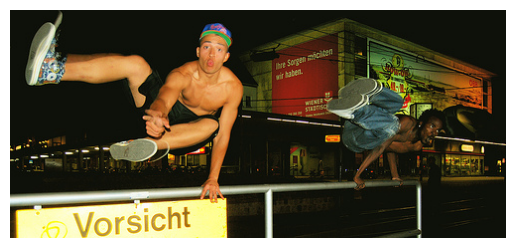

In [ ]:
show_caption("1001545525.jpg")


----------- Actual Captions -----------
a dog walking through a stream carrying a white towel in its mouth

----------- Predicted Caption -----------
the brown dog is running across a beach


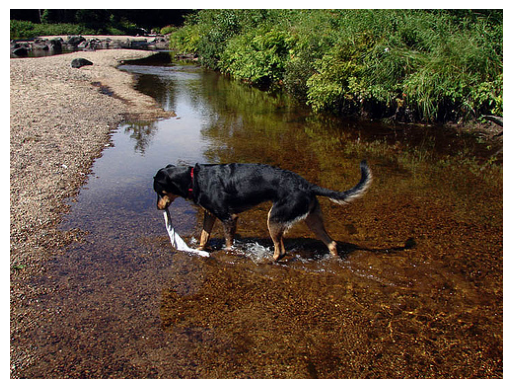

In [ ]:
show_caption("1363843090.jpg")

----------- Actual Captions -----------
a golden retriever has on a collar and a harness and has a muddy lower body

----------- Predicted Caption -----------
a dog is walking through a grassy pool with the water with a blue sky


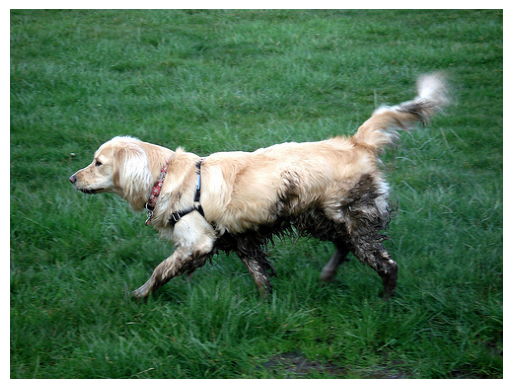

In [ ]:
show_caption("1522787272.jpg")

----------- Actual Captions -----------
a band of men and women in tropical shirts is playing in front of a visitors information center

----------- Predicted Caption -----------
a man and woman in a red t shirt and a white dress is looking at a man who has a baby and is standing next to her face


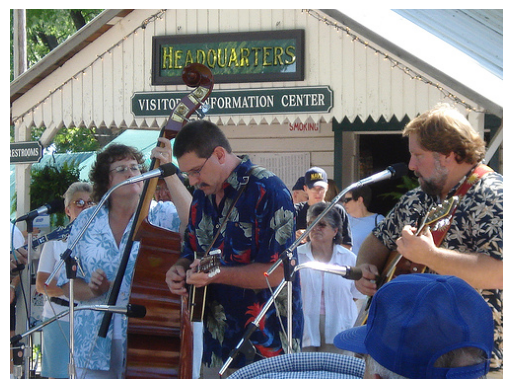

In [ ]:
show_caption("1561665101.jpg")

----------- Actual Captions -----------
the players of the baseball team are standing on the field with many people watching from the stands

----------- Predicted Caption -----------
two soccer player are running against a tennis ball while another is trying to score


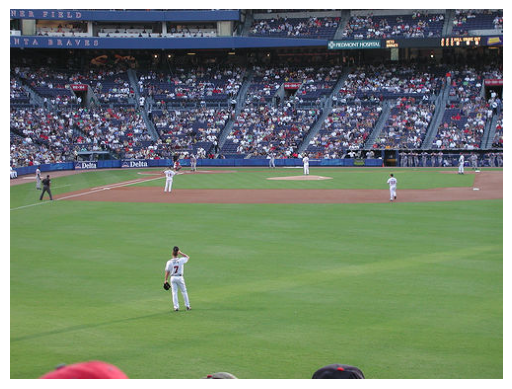

In [ ]:
show_caption("134206.jpg")

----------- Actual Captions -----------
a man dressed in a white shirt blue baseball cap while wearing gloves holding a red and white checkered food wrapping

----------- Predicted Caption -----------
a man in a white shirt is sitting in the middle of a large city


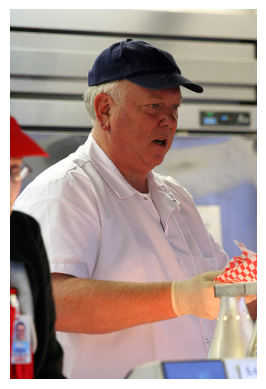

In [ ]:
show_caption("1418019748.jpg")

----------- Actual Captions -----------
a boy plays with outstretched arms on the sidewalk next to a cobblestone street

----------- Predicted Caption -----------
a man wearing a blue shirt is walking down a city street that has a blue bag on his head


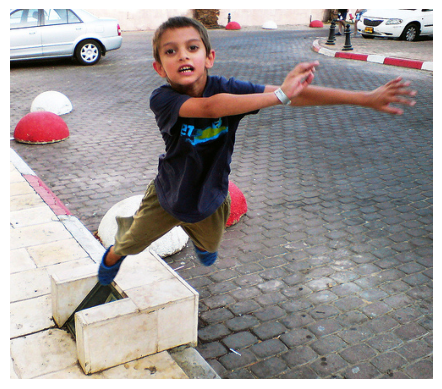

In [ ]:
show_caption("1414779054.jpg")

new image


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# load VGG16 and remove classification layer
vgg = VGG16()
vgg = Model(inputs=vgg.inputs, outputs=vgg.layers[-2].output)


In [ ]:
def extract_features_new_image(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    feature = vgg.predict(image, verbose=0)
    return feature


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def predict_new_image(image_path):
    # extract image features
    image_feature = extract_features_new_image(image_path)

    # generate caption
    caption = predict_caption(
        model,
        image_feature,
        tokenizer,
        max_length
    )

    # clean caption
    caption = caption.replace("startseq", "").replace("endseq", "").strip()

    # show image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    print("Predicted Caption:")
    print(caption)


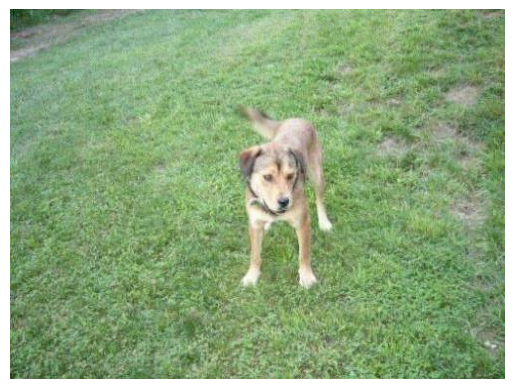

Predicted Caption:
a brown dog is walking down the beach on a rocky field


In [ ]:
# give ANY image path (new image)
image_path = "/content/dog.34.jpg"
# OR upload a new image and give its path

predict_new_image(image_path)


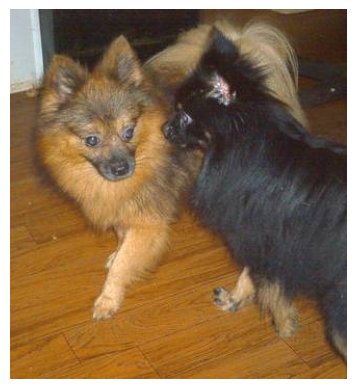

Predicted Caption:
a brown and black dog is running across a lake covered water by a stick


In [ ]:
# give ANY image path (new image)
image_path = "/content/dog.39.jpg"
# OR upload a new image and give its path

predict_new_image(image_path)

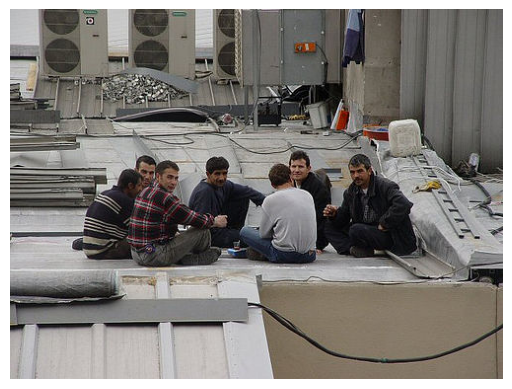

Predicted Caption:
a group of people are sitting in the kitchen and another man stands and a man with an orange dress


In [ ]:
# give ANY image path (new image)
image_path = "/content/test1.jpg"
# OR upload a new image and give its path

predict_new_image(image_path)

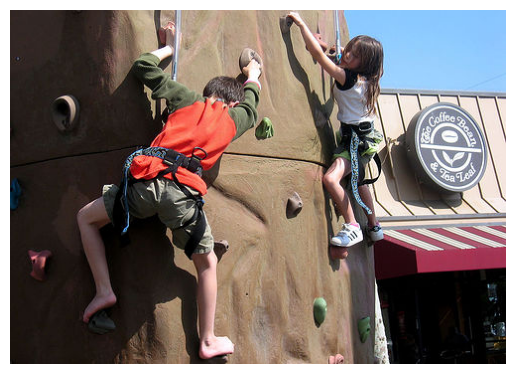

Predicted Caption:
two young boys are standing at a table in an outdoor alley


In [ ]:
# give ANY image path (new image)
image_path = "/content/test2.jpg"
# OR upload a new image and give its path

predict_new_image(image_path)